In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
path = '/content/drive/MyDrive/作业/人工智能安全作业1'
os.chdir(path)
!ls

Lenet.ipynb


In [8]:
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [9]:
# Parameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
GRAYSCALE = False

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [12]:
data_dir = './data/cifar10'

train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [13]:
class LeNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Linear(84, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

In [14]:
torch.manual_seed(RANDOM_SEED)
model = LeNet().to(DEVICE)

In [17]:
def evaluation(data_loader):
    total, correct = 0, 0
    for data in data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
# train
loss_arr = []
loss_epoch_arr = []

lr = [0.01, 0.05, 0.1, 0.5]
momentum = 0.9
weight_decay = 5e-4

loss_fn = nn.CrossEntropyLoss()
for item in lr:
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  # optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(0, NUM_EPOCHS):
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, NUM_EPOCHS, evaluation(test_loader), evaluation(train_loader)))


lr：0.10
Epoch: 0/50, Test acc: 39.34, Train acc: 40.11
Epoch: 1/50, Test acc: 47.07, Train acc: 48.52
Epoch: 2/50, Test acc: 46.40, Train acc: 47.22
Epoch: 3/50, Test acc: 51.86, Train acc: 54.08
Epoch: 4/50, Test acc: 53.68, Train acc: 56.03
Epoch: 5/50, Test acc: 53.07, Train acc: 56.52
Epoch: 6/50, Test acc: 54.40, Train acc: 58.14
Epoch: 7/50, Test acc: 53.72, Train acc: 57.13
Epoch: 8/50, Test acc: 57.61, Train acc: 61.76
Epoch: 9/50, Test acc: 55.93, Train acc: 60.34
Epoch: 10/50, Test acc: 53.99, Train acc: 58.70
Epoch: 11/50, Test acc: 55.35, Train acc: 59.96
Epoch: 12/50, Test acc: 55.36, Train acc: 59.85
Epoch: 13/50, Test acc: 56.60, Train acc: 62.39
Epoch: 14/50, Test acc: 54.96, Train acc: 59.57
Epoch: 15/50, Test acc: 57.55, Train acc: 62.05
Epoch: 16/50, Test acc: 57.91, Train acc: 62.75
Epoch: 17/50, Test acc: 53.98, Train acc: 58.79
Epoch: 18/50, Test acc: 56.56, Train acc: 61.72
Epoch: 19/50, Test acc: 58.62, Train acc: 64.27
Epoch: 20/50, Test acc: 55.90, Train acc: 

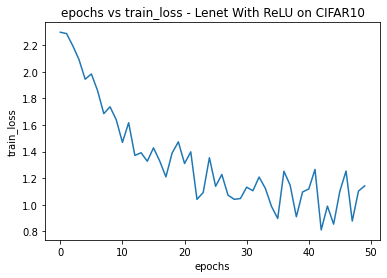

In [ ]:
## draw again
from matplotlib.pyplot import MultipleLocator

plt.plot(loss_epoch_arr)
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("epochs vs train_loss - Lenet With ReLU on CIFAR10")
plt.show()

In [ ]:
save_model = True
if save_model:
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('model', exist_ok=True)
    torch.save(state, './model/lenet_sgd.ckpt')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

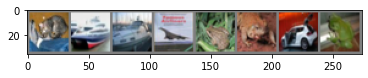

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:    cat  ship  ship  ship  frog  frog   car  frog


In [ ]:
# test
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:8]
labels = labels[:8]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

outputs = model(images.to(DEVICE))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62.97 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 71 %
Accuracy of  bird : 54 %
Accuracy of   cat : 41 %
Accuracy of  deer : 51 %
Accuracy of   dog : 54 %
Accuracy of  frog : 63 %
Accuracy of horse : 64 %
Accuracy of  ship : 87 %
Accuracy of truck : 74 %
